COMP9517 Assignment 1
Fan Zhu z5245075
Program that read in image files from the Sergei Prokudin-Gorsky collection and converts the images into coloured images with proper alignemnt in all 3 layers.
The program also implements image pyramid method to handle high resolution images.

This program uses functions from opencv and so alot of the function usage are referenced from 
https://docs.opencv.org/3.4/
and 
https://opencv-python-tutroals.readthedocs.io/

In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def split_img(input_image):
    og_x = int(np.around(input_image.shape[0]/3))
    og_y = input_image.shape[1]

    a = input_image[0:og_x, :, 0]
    b = input_image[og_x:2*og_x,:,0]
    c = input_image[og_x*2:input_image.shape[0]-1, :, 0]
    
    return a, b, c

In [3]:
def img_alignment(input_image):
    og_x = int(np.around(input_image.shape[0]/3))
    og_y = input_image.shape[1]
    
    a, b, c = split_img(input_image)
    
    '''
    #Task 1 original image split into 3
    print()
    plt.imshow(a, cmap = "gray")
    plt.show()
    plt.imshow(b, cmap = "gray")
    plt.show()
    plt.imshow(c, cmap = "gray")
    plt.show()
   
    '''
    #initialise empty numpy arrays to hold images
    d = np.zeros((og_x, og_y, 3), dtype = np.uint8) 
    d[:,:,0] = c
    d[:,:,1] = b
    d[:,:,2] = a

    d2 = np.zeros((og_x, og_y, 3), dtype = np.uint8)   
    r = a.copy()
    g = b.copy()
    b = c.copy()

    align_img = align(d2, r, g, b)
    plt.imshow(d)
    plt.show()
    d = cv2.cvtColor(d, cv2.COLOR_RGB2BGR)
    cv2.imwrite('T1.jpg', d)
    
    return align_img

In [4]:
def edge_filter(img):
    #apply sobel filtering in x and y
    F_x = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=5)
    F_y = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=5)
    
    out_grad = cv2.addWeighted(np.absolute(F_x), 0.5, np.absolute(F_y), 0.5, 0)
    
    #Laplacian filter
    #dst = cv2.Laplacian(img, cv2.CV_32F, ksize=3)
    #out_grad = cv2.convertScaleAbs(dst)
    
    #Canny edge detection filter
    #out_grad = cv2.Canny(img, 100, 200)
    
    #overall, any of the 3 filters work and improve the result of alignment.
    return out_grad

In [5]:
def quality_score(match, in_g):
    x = match.shape[0]
    y = match.shape[1]
    
    #apply edge detection (high pass) filters for Task 3
    sobel_match = edge_filter(match)
    sobel_in_g = edge_filter(in_g)
    
    #without filter initially
    #sobel_match = match
    #sobel_in_g = in_g
    
    
    crop_x = int(x/2 - 75)
    crop_y = int(y/2 - 75)
    crop_match = sobel_match[crop_x:crop_x+150, crop_y:crop_y+150]
    
    crop_in_g = sobel_in_g[crop_x:crop_x+150, crop_y:crop_y+150]
    
    
    new_g = crop_in_g.copy()
    new_x = new_g.shape[0]
    new_y = new_g.shape[1]
    res = cv2.matchTemplate(new_g, crop_match, cv2.TM_CCORR_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    max_val_old = max_val
    
    plt.imshow(new_g)
    plt.show()
    
    temp_g = new_g.copy()
    temp_g = cv2.cvtColor(temp_g, cv2.COLOR_RGB2BGR)
    cv2.imwrite('crop.jpg', temp_g)
    
    (shift_x, shift_y) = (0, 0)
    
    #20 pixel scan (20x20) used 1st e.g. range(-10, 11)
    #changed to 30x30 pixel for better result e.g. range(-15, 16)
    for i in range(-15, 16):
        for j in range(-15, 16):
            
            T_matrix = np.array([[1, 0, i], [0, 1, j]], dtype = np.float32)
            shifted_g = cv2.warpAffine(new_g, T_matrix, (new_y, new_x))
            new_res = cv2.matchTemplate(shifted_g, crop_match, cv2.TM_CCOEFF)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(new_res)
            if max_val > max_val_old:
                max_val_old = max_val
                (shift_x, shift_y) = (i, j)
            
    
    print('(x, ty):', (shift_x, shift_y))
    
    T_matrix_final = np.array([[1, 0, shift_x], [0, 1, shift_y]], dtype = np.float32)   
    shifted_final = cv2.warpAffine(in_g, T_matrix_final, (y, x))
    return shifted_final

In [6]:
def align(match, in_r, in_g, in_b):
    in_r = np.uint8(in_r)
    in_g = np.uint8(in_g)
    in_b = np.uint8(in_b)
    match[:, :, 2] = in_r

    print('blue')
    temp_b = quality_score(in_r, in_b)
    print('green')
    temp_g = quality_score(in_r, in_g)
    match[:, :, 0] = temp_b.copy()
    match[:, :, 1] = temp_g.copy()
    for i in range(3):
        match[:, :, i] = match[:, :, i].astype(dtype = np.uint8) 
    
    return match


In [7]:
def pyramid(in_img):
    r, g, b = split_img(in_img)
    min_x = min(r.shape[0], g.shape[0], b.shape[0])
    a_img = np.zeros((min_x, in_img.shape[1], 3), dtype = np.uint8)
    
    if r.shape[0] != min_x:
        r = r[0:min_x, :]
    if b.shape[0] != min_x:
        b = b[0:min_x, :]
    if g.shape[0] != min_x:
        g = g[0:min_x, :]
        
    a_img[:,:,0] = r.copy()
    a_img[:,:,1] = g.copy()
    a_img[:,:,2] = b.copy()
        
    
    bx, by, gx, gy = pyramid_recur(0, 3, a_img)
    cv2.imwrite('P1.jpg', a_img)
    a_img = cv2.cvtColor(a_img, cv2.COLOR_RGB2BGR)
    plt.imshow(a_img)
    plt.show()
    
    
    T_matrix_b = np.array([[1, 0, bx], [0, 1, by]], dtype = np.float32)
    
    T_matrix_g = np.array([[1, 0, gx], [0, 1, gy]], dtype = np.float32)
    
    b_img = np.zeros((min_x, in_img.shape[1], 3), dtype = np.uint8)
    b_img[:,:,0] = r.copy()
    b_img[:,:,1] = g.copy()
    b_img[:,:,2] = b.copy()
   
    
    b_img[:,:, 1] = cv2.warpAffine(g, T_matrix_g, (g.shape[1], min_x))
    b_img[:,:, 2] = cv2.warpAffine(b, T_matrix_b, (b.shape[1], min_x))

    
    b_img = cv2.cvtColor(b_img, cv2.COLOR_RGB2BGR)
    plt.imshow(b_img)
    plt.show()
    
    return b_img

In [8]:
def pyramid_recur(lvl, end, img):
    if lvl == end:
        #do task 1 stuff
        d_i = np.empty((img.shape[0], img.shape[1], 3), dtype = np.uint8)
        bx, by, gx, gy, temp = pyr_align(d_i, img[:, :, 0], img[:, :, 1], img[:, :, 2])
        return bx, by, gx, gy
    else:
        down_layer = cv2.pyrDown(img)  
        up_layer = cv2.pyrUp(down_layer)

        x = img.shape[0]
        y = img.shape[1]
        
        up_layer = up_layer[0:x, 0:y]
        dif = cv2.subtract(img, up_layer)
        
        
        lvl+=1
        bx, by, gx, gy = pyramid_recur(lvl, end, down_layer)
        '''
        up_aligned = cv2.pyrUp(aligned_img)
        print(dif.shape)
        print(up_aligned.shape)
        x2 = dif.shape[0]
        y2 = dif.shape[1]
        
        up_aligned = up_aligned[0:x2, 0:y2]
        print(up_aligned.shape)
        out_img = cv2.add(up_aligned, dif)
        '''
        bx *= 2
        by *= 2
        gx *= 2
        gy *= 2

    return bx, by, gx, gy


In [9]:
def pyr_quality_score(match, in_g):
    x = match.shape[0]
    y = match.shape[1]

    #apply edge detection (high pass) filters
    sobel_match = edge_filter(match)
    sobel_in_g = edge_filter(in_g)
    
    #without filter initially
    #sobel_match = match
    #sobel_in_g = in_g
    
    
    crop_x = int(x/2 - 75)
    crop_y = int(y/2 - 75)
    crop_match = sobel_match[crop_x:crop_x+150, crop_y:crop_y+150]
    
    crop_in_g = sobel_in_g[crop_x:crop_x+150, crop_y:crop_y+150]
    
    
    new_g = crop_in_g.copy()
    new_x = new_g.shape[0]
    new_y = new_g.shape[1]
    res = cv2.matchTemplate(new_g, crop_match, cv2.TM_CCORR_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    max_val_old = max_val
    #print('OLD', max_val_old)
    
    plt.imshow(new_g)
    plt.show()
    
    temp_g = new_g.copy()
    #temp_g = cv2.cvtColor(temp_g, cv2.COLOR_RGB2BGR)
    cv2.imwrite('crop.jpg', temp_g)
    
    (shift_x, shift_y) = (0, 0)
    #20 pixel scan (20x20) used 1st e.g. range(-10, 11)
    #changed to 30x30 pixel for better result e.g. range(-15, 16)
    for i in range(-15, 16):
        for j in range(-15, 16):
            
            T_matrix = np.array([[1, 0, i], [0, 1, j]], dtype = np.float32)
            shifted_g = cv2.warpAffine(new_g, T_matrix, (new_y, new_x))
            #plt.imshow(shifted_g)
            #plt.show()
            new_res = cv2.matchTemplate(shifted_g, crop_match, cv2.TM_CCOEFF)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(new_res)
            #print('inside', min_val)
            #print(i, j)
            if max_val > max_val_old:
                max_val_old = max_val
                (shift_x, shift_y) = (i, j)
            
    print('(x, ty):', (shift_x, shift_y))

    return shift_x, shift_y, match

In [10]:
def pyr_align(match, in_r, in_g, in_b):
    in_r = np.uint8(in_r)
    in_g = np.uint8(in_g)
    in_b = np.uint8(in_b)
    
    match[:, :, 2] = in_r
    '''
    print()
    print('sboel')
    s_r = sobel(in_r) 
    s_g = sobel(in_g)
    s_b = sobel(in_b)
    print(s_r.shape)
    '''
    print('blue')
    bx, by, temp_b = pyr_quality_score(in_r, in_b)
    print('green')
    gx, gy, temp_g = pyr_quality_score(in_r, in_g)
    match[:, :, 0] = temp_b.copy()
    match[:, :, 1] = temp_g.copy()
    for i in range(3):
        match[:, :, i] = match[:, :, i].astype(dtype = np.uint8) 

    return bx, by, gx, gy, match

In [11]:
def contrast(in_img):
    alpha = 1.0 
    beta = 0
    new_img = np.zeros(in_img.shape, in_img.dtype)
    for y in range(in_img.shape[0]):
        for x in range(in_img.shape[1]):
            for c in range(in_img.shape[2]):
                new_img[y,x,c] = np.clip(alpha*in_img[y,x,c] + beta, 0, 255)
    
    return new_img

In [12]:
def gammaCorrection(img):
    #https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html
    gamma = 1.0
    ## [changing-contrast-brightness-gamma-correction]
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)

    res = cv2.LUT(img, lookUpTable)
    ## [changing-contrast-brightness-gamma-correction]

    img_gamma_corrected = cv2.hconcat([img, res])
    return img_gamma_corrected

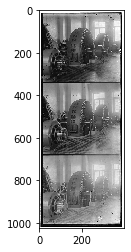

blue


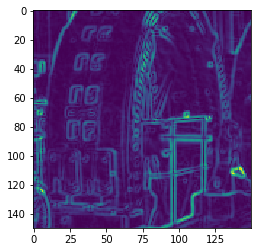

(x, ty): (2, 11)
green


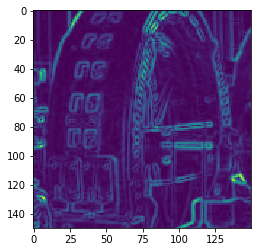

(x, ty): (1, 6)


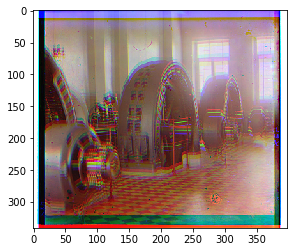

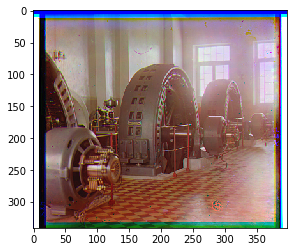

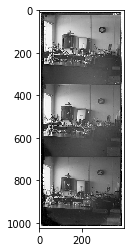

blue


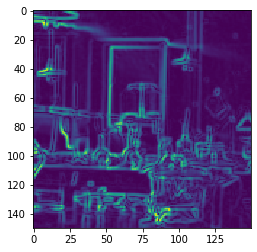

(x, ty): (8, 11)
green


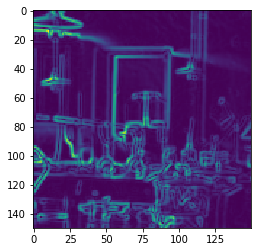

(x, ty): (5, 5)


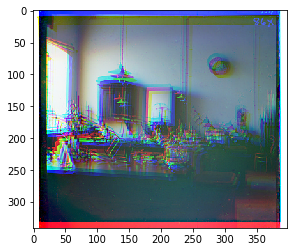

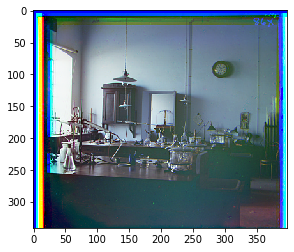

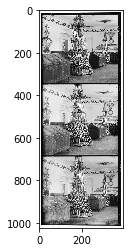

blue


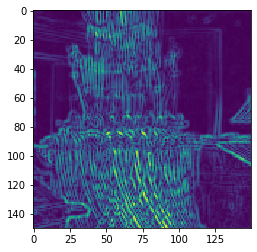

(x, ty): (1, 13)
green


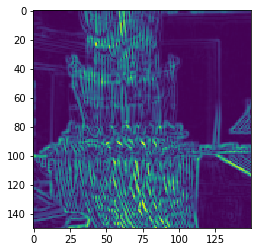

(x, ty): (2, 7)


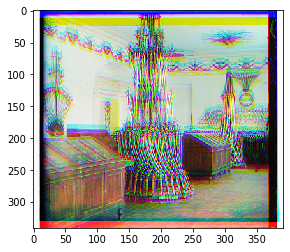

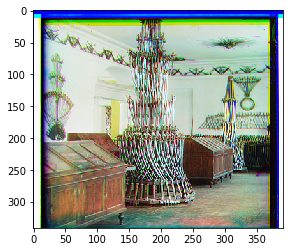

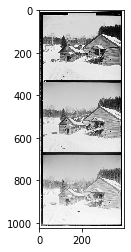

blue


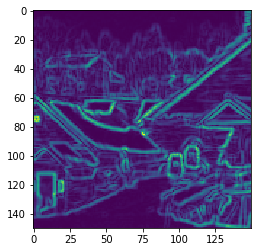

(x, ty): (3, 9)
green


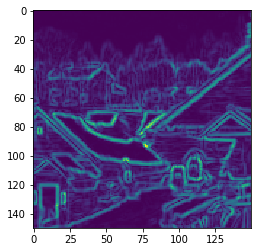

(x, ty): (2, 1)


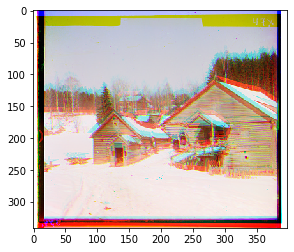

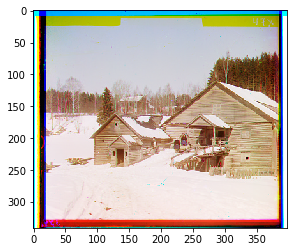

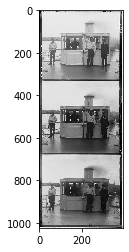

blue


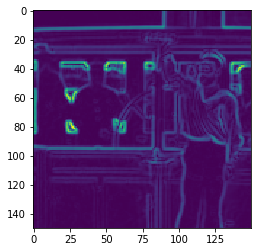

(x, ty): (3, -1)
green


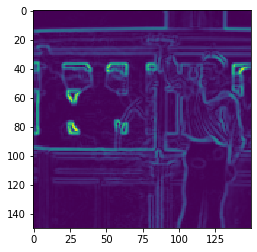

(x, ty): (2, -2)


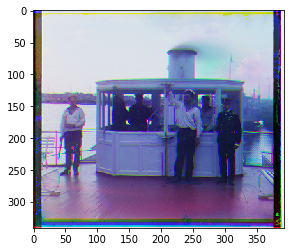

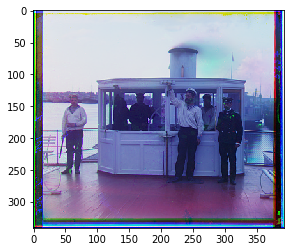

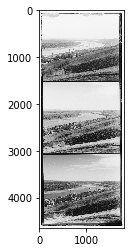

blue


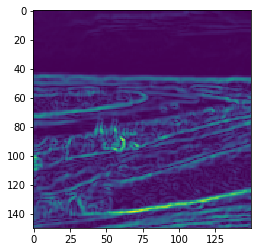

(x, ty): (-2, 7)
green


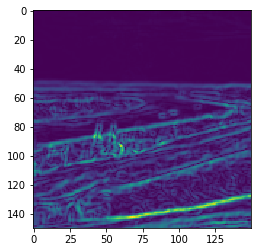

(x, ty): (-1, 3)


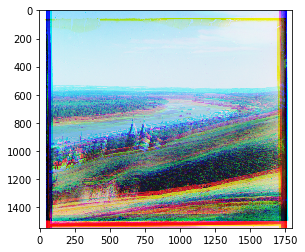

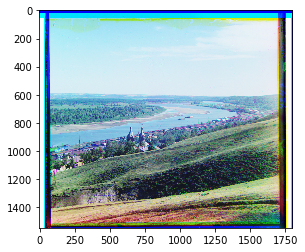

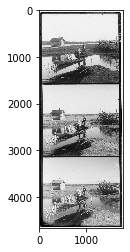

blue


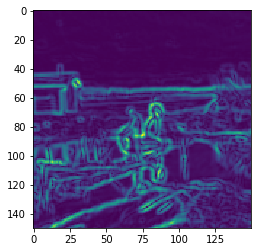

(x, ty): (-1, 8)
green


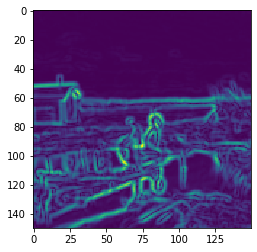

(x, ty): (0, 1)


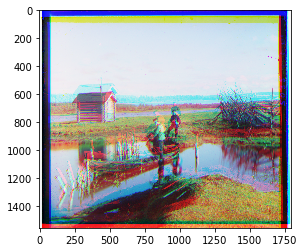

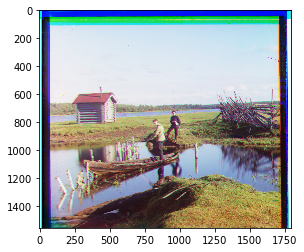

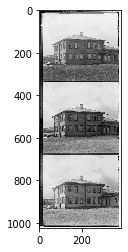

blue


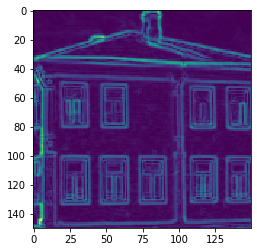

(x, ty): (1, 6)
green


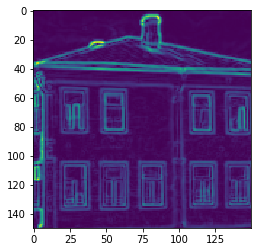

(x, ty): (1, 2)


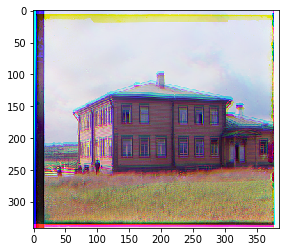

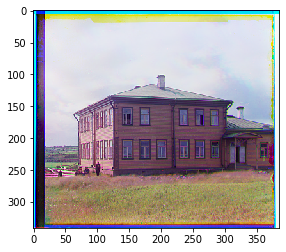

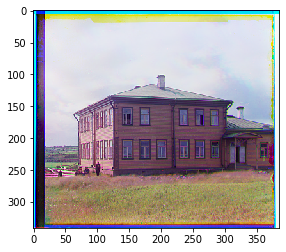

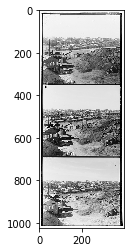

blue


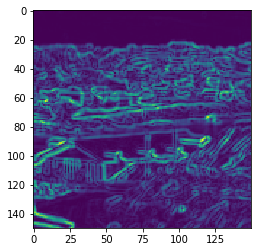

(x, ty): (4, 10)
green


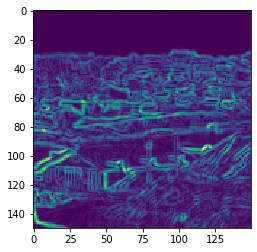

(x, ty): (3, 4)


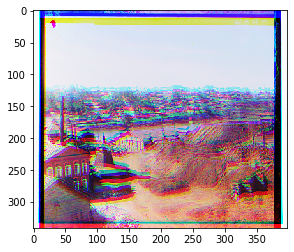

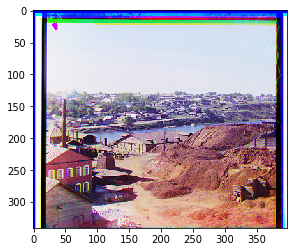

Current


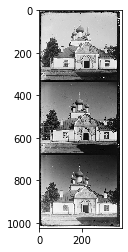

blue


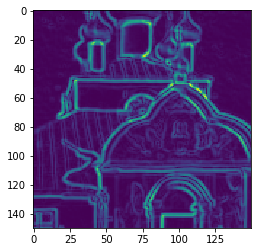

(x, ty): (3, 3)
green


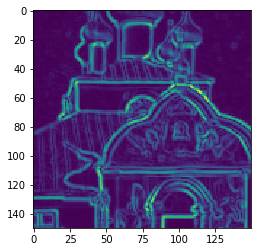

(x, ty): (3, 2)


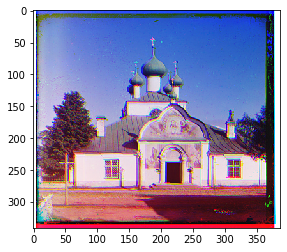

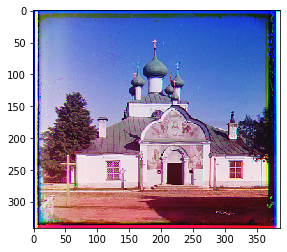

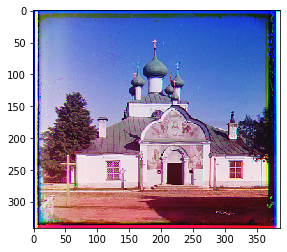

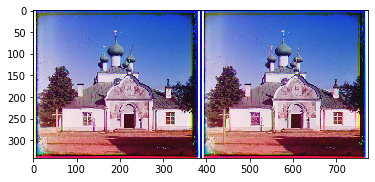

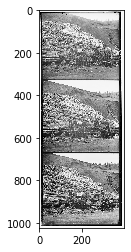

blue


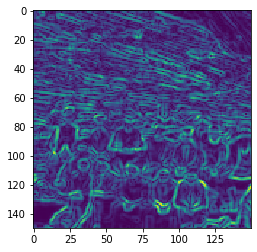

(x, ty): (3, 8)
green


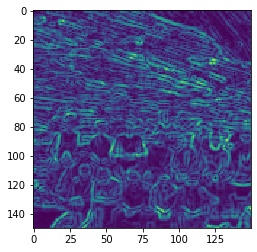

(x, ty): (2, 3)


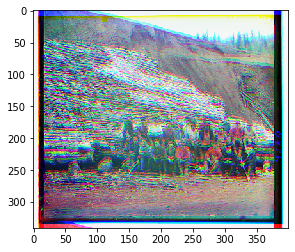

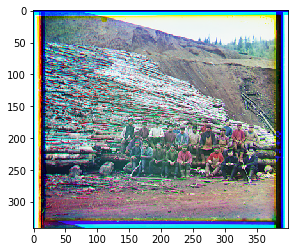

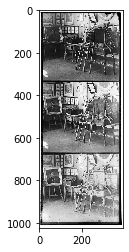

blue


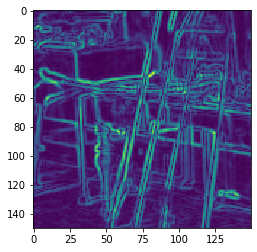

(x, ty): (2, 15)
green


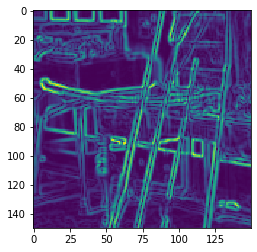

(x, ty): (2, 8)


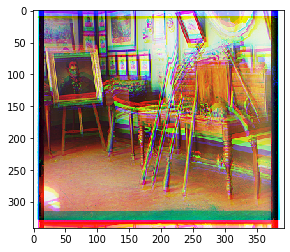

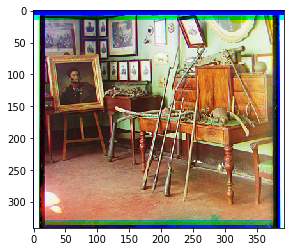

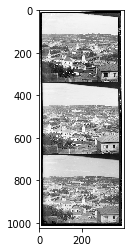

blue


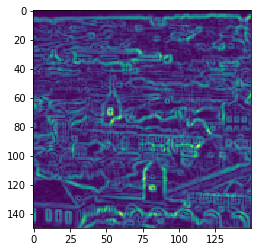

(x, ty): (1, 12)
green


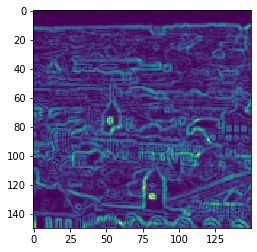

(x, ty): (2, 6)


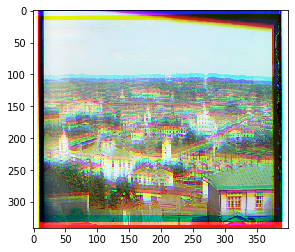

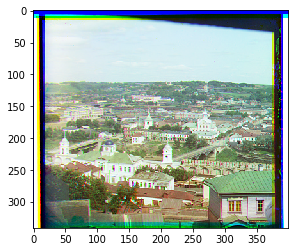

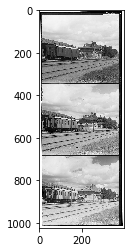

blue


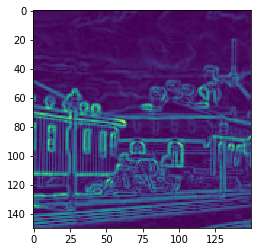

(x, ty): (4, 11)
green


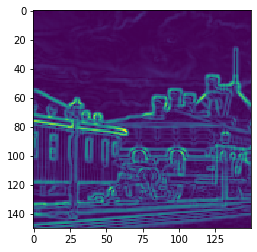

(x, ty): (3, 5)


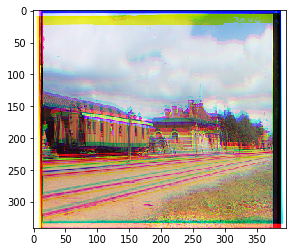

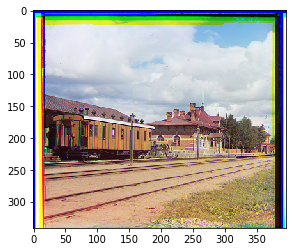

In [13]:

if __name__ == "__main__":
    
    imgT1 = cv2.imread('s1.jpg')
    imgT2 = cv2.imread('s2.jpg')
    imgT3 = cv2.imread('s3.jpg')
    imgT4 = cv2.imread('s4.jpg')
    imgT5 = cv2.imread('s5.jpg')
    
    imgHD1 = cv2.imread('00549u.jpg')
    imgHD2 = cv2.imread('00911u.jpg')
    
    #Task 1 results
    
    plt.imshow(imgT1)
    plt.show()
    T1_align = img_alignment(imgT1)
    plt.imshow(T1_align)
    plt.show()
    T1_align = cv2.cvtColor(T1_align, cv2.COLOR_RGB2BGR)
    cv2.imwrite('T1_o.jpg', T1_align)
    
    
    
    plt.imshow(imgT2)
    plt.show()
    T2_align = img_alignment(imgT2)
    plt.imshow(T2_align)
    plt.show()
    T2_align = cv2.cvtColor(T2_align, cv2.COLOR_RGB2BGR)
    cv2.imwrite('T22.jpg', T2_align)
    #T2_Gamma = gammaCorrection(T2_align)
    #plt.imshow(T2_Gamma)
    #plt.show()
    
    
    
    plt.imshow(imgT3)
    plt.show()
    T3_align = img_alignment(imgT3)
    plt.imshow(T3_align)
    plt.show()
    T3_align = cv2.cvtColor(T3_align, cv2.COLOR_RGB2BGR)
    cv2.imwrite('T1.jpg', T3_align)
    
    plt.imshow(imgT4)
    plt.show()
    T4_align = img_alignment(imgT4)
    plt.imshow(T4_align)
    plt.show()
    plt.imshow(imgT5)
    plt.show()
    T5_align = img_alignment(imgT5)
    plt.imshow(T5_align)
    plt.show()
    
    #Task 2 results
    plt.imshow(imgHD1)
    plt.show()
    pyr_img = pyramid(imgHD1)
    
    pyr_img = cv2.cvtColor(pyr_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('pyr_img1.jpg', pyr_img)
    
    
    plt.imshow(imgHD2)
    plt.show()
    pyr_img = pyramid(imgHD2)
    pyr_img = cv2.cvtColor(pyr_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('pyr_img2.jpg', pyr_img)
   
    
    #Task 3 test
    T3_img1 = cv2.imread('T3_1.jpg')
    T3_img2 = cv2.imread('T3_2.jpg')
    T3_img5 = cv2.imread('T3_5.jpg')
    T3_img6 = cv2.imread('T3_6.jpg')
    T3_img7 = cv2.imread('T3_7.jpg')
    
    T3_img1HQ = cv2.imread('T3_1HQ.jpg')
    T3_img2HQ = cv2.imread('T3_2HQ.jpg')
    
    plt.imshow(T3_img1)
    plt.show()
    T3_1_align = img_alignment(T3_img1)
    plt.imshow(T3_1_align)
    plt.show()
    T3_1_Con = contrast(T3_1_align)
    plt.imshow(T3_1_Con)
    plt.show()
    
    plt.imshow(T3_img2)
    plt.show()
    T3_2_align = img_alignment(T3_img2)
    plt.imshow(T3_2_align)
    plt.show()    
    
    print('Current')
    plt.imshow(T3_img1HQ)
    plt.show()
    T3_1_alignHQ = img_alignment(T3_img1HQ)
    plt.imshow(T3_1_alignHQ)
    plt.show() 
    T3_1_ConHQ = contrast(T3_1_alignHQ)
    plt.imshow(T3_1_ConHQ)
    plt.show()
    T3_1_GammaHQ = gammaCorrection(T3_1_alignHQ)
    plt.imshow(T3_1_GammaHQ)
    plt.show()
    
    plt.imshow(T3_img2HQ)
    plt.show()
    T3_2_alignHQ = img_alignment(T3_img2HQ)
    plt.imshow(T3_2_alignHQ)
    plt.show() 

    plt.imshow(T3_img5)
    plt.show()
    T3_5_align = img_alignment(T3_img5)
    plt.imshow(T3_5_align)
    plt.show()
    
    plt.imshow(T3_img6)
    plt.show()
    T3_6_align = img_alignment(T3_img6)
    plt.imshow(T3_6_align)
    plt.show() 
    
    plt.imshow(T3_img7)
    plt.show()
    T3_7_align = img_alignment(T3_img7)
    plt.imshow(T3_7_align)
    plt.show() 
